# Keras starter kit [full training set, UNet]

## Setup

In [1]:

import numpy as np
import torch
import torch.nn as nn
import torchvision
import cupy
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pytorch_lightning
import segmentation_models_pytorch as smp
import pytorch_lightning as pl
import pytorch_lightning.plugins
from skimage.transform import resize as resize_ski
from pytorch_lightning.strategies.ddp import DDPStrategy
import os

from scipy.ndimage import distance_transform_edt

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import glob
import time
import PIL.Image as Image
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
from sklearn.model_selection import KFold
from tqdm import tqdm
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data


# Data config
# DATA_DIR = '/kaggle/input/vesuvius-challenge-ink-detection/'
DATA_DIR = '/home/fummicc1/codes/competitions/kaggle-ink-detection'
BUFFER = 160 # Half-size of papyrus patches we'll use as model inputs
Z_LIST = list(range(0, 65, 4))  # Offset of slices in the z direction
Z_DIM = len(Z_LIST)  # Number of slices in the z direction. Max value is 64 - Z_START
SHARED_HEIGHT = 4000  # Max height to resize all papyrii

# Model config
BATCH_SIZE = 64

# backbone = "mit_b1"
# backbone = "efficientnet-b5"
backbone = "se_resnext50_32x4d"
# backbone = "resnext50_32x4d"
# backbone = "resnet50"

device = torch.device("cuda")
threshold = 0.5
num_workers = 8
exp = 1e-7
mask_padding = 200

num_epochs = 30
lr = 1e-3

pytorch_lightning.seed_everything(seed=42)
torch.set_float32_matmul_precision('high')

Global seed set to 42


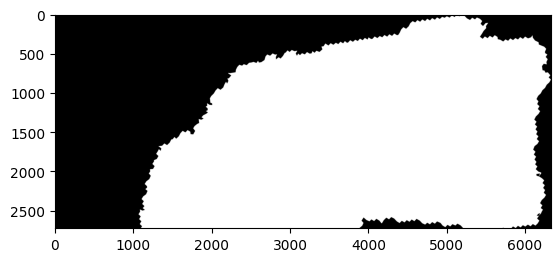

In [2]:
# plt.imshow(Image.open(DATA_DIR + "/train/1/ir.png"), cmap="gray")
# plt.imshow(Image.open(DATA_DIR + "/train/2/ir.png"), cmap="gray")
# plt.imshow(Image.open(DATA_DIR + "/train/3/ir.png"), cmap="gray")
plt.imshow(Image.open(DATA_DIR + "/test/a/mask.png"), cmap="gray")
# plt.imshow(Image.open(DATA_DIR + "/test/b/mask.png"), cmap="gray")

## Load up the training data

In [3]:
import cupy as cp
xp = cp

delta_lookup = {
    "xx": xp.array([[1, -2, 1]], dtype=float),
    "yy": xp.array([[1], [-2], [1]], dtype=float),
    "xy": xp.array([[1, -1], [-1, 1]], dtype=float),
}

def operate_derivative(img_shape, pair):
    assert len(img_shape) == 2
    delta = delta_lookup[pair]
    fft = xp.fft.fftn(delta, img_shape)
    return fft * xp.conj(fft)

def soft_threshold(vector, threshold):
    return xp.sign(vector) * xp.maximum(xp.abs(vector) - threshold, 0)

def back_diff(input_image, dim):
    assert dim in (0, 1)
    r, n = xp.shape(input_image)
    size = xp.array((r, n))
    position = xp.zeros(2, dtype=int)
    temp1 = xp.zeros((r+1, n+1), dtype=float)
    temp2 = xp.zeros((r+1, n+1), dtype=float)
    
    temp1[position[0]:size[0], position[1]:size[1]] = input_image
    temp2[position[0]:size[0], position[1]:size[1]] = input_image
    
    size[dim] += 1
    position[dim] += 1
    temp2[position[0]:size[0], position[1]:size[1]] = input_image
    temp1 -= temp2
    size[dim] -= 1
    return temp1[0:size[0], 0:size[1]]

def forward_diff(input_image, dim):
    assert dim in (0, 1)
    r, n = xp.shape(input_image)
    size = xp.array((r, n))
    position = xp.zeros(2, dtype=int)
    temp1 = xp.zeros((r+1, n+1), dtype=float)
    temp2 = xp.zeros((r+1, n+1), dtype=float)
        
    size[dim] += 1
    position[dim] += 1

    temp1[position[0]:size[0], position[1]:size[1]] = input_image
    temp2[position[0]:size[0], position[1]:size[1]] = input_image
    
    size[dim] -= 1
    temp2[0:size[0], 0:size[1]] = input_image
    temp1 -= temp2
    size[dim] += 1
    return -temp1[position[0]:size[0], position[1]:size[1]]

def iter_deriv(input_image, b, scale, mu, dim1, dim2):
    g = back_diff(forward_diff(input_image, dim1), dim2)
    d = soft_threshold(g + b, 1 / mu)
    b = b + (g - d)
    L = scale * back_diff(forward_diff(d - b, dim2), dim1)
    return L, b

def iter_xx(*args):
    return iter_deriv(*args, dim1=1, dim2=1)

def iter_yy(*args):
    return iter_deriv(*args, dim1=0, dim2=0)

def iter_xy(*args):
    return iter_deriv(*args, dim1=0, dim2=1)

def iter_sparse(input_image, bsparse, scale, mu):
    d = soft_threshold(input_image + bsparse, 1 / mu)
    bsparse = bsparse + (input_image - d)
    Lsparse = scale * (d - bsparse)
    return Lsparse, bsparse


def denoise_image(input_image, iter_num=100, fidelity=150, sparsity_scale=10, continuity_scale=0.5, mu=1):
    image_size = xp.shape(input_image)
    #print("Initialize denoising")
    norm_array = (
        operate_derivative(image_size, "xx") + 
        operate_derivative(image_size, "yy") + 
        2 * operate_derivative(image_size, "xy")
    )
    norm_array += (fidelity / mu) + sparsity_scale ** 2
    b_arrays = {
        "xx": xp.zeros(image_size, dtype=float),
        "yy": xp.zeros(image_size, dtype=float),
        "xy": xp.zeros(image_size, dtype=float),
        "L1": xp.zeros(image_size, dtype=float),
    }
    g_update = xp.multiply(fidelity / mu, input_image)
    for i in tqdm(range(iter_num), total=iter_num):
        #print(f"Starting iteration {i+1}")
        g_update = xp.fft.fftn(g_update)
        if i == 0:
            g = xp.fft.ifftn(g_update / (fidelity / mu)).real
        else:
            g = xp.fft.ifftn(xp.divide(g_update, norm_array)).real
        g_update = xp.multiply((fidelity / mu), input_image)
        
        #print("XX update")
        L, b_arrays["xx"] = iter_xx(g, b_arrays["xx"], continuity_scale, mu)
        g_update += L
        
        #print("YY update")
        L, b_arrays["yy"] = iter_yy(g, b_arrays["yy"], continuity_scale, mu)
        g_update += L
        
        #print("XY update")
        L, b_arrays["xy"] = iter_xy(g, b_arrays["xy"], 2 * continuity_scale, mu)
        g_update += L
        
        #print("L1 update")
        L, b_arrays["L1"] = iter_sparse(g, b_arrays["L1"], sparsity_scale, mu)
        g_update += L
        
    g_update = xp.fft.fftn(g_update)
    g = xp.fft.ifftn(xp.divide(g_update, norm_array)).real
    
    g[g < 0] = 0
    g -= g.min()
    g /= g.max()
    return g

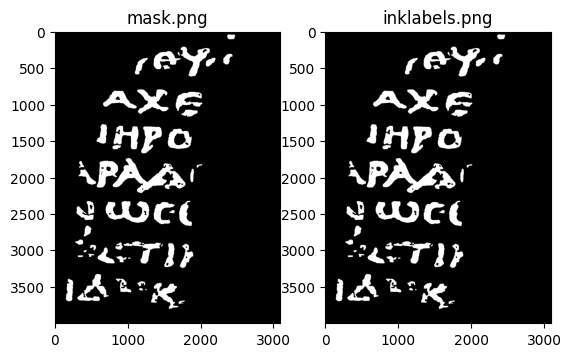

In [4]:
def resize(img):
    current_height, current_width = img.shape    
    aspect_ratio = current_width / current_height
    new_height = SHARED_HEIGHT
    new_width = int(SHARED_HEIGHT * aspect_ratio)
    new_size = (new_width, new_height)
    # (W, H)の順で渡すが結果は(H, W)になっている
    img = cv2.resize(img, new_size)
    return img

def load_mask(split, index):
    img = cv2.imread(f"{DATA_DIR}/{split}/{index}/mask.png", 0) // 255
    img = np.pad(img, 1, constant_values=0)
    dist = distance_transform_edt(img)
    img[dist <= mask_padding] = 0
    img = img[1:-1, 1:-1]
    img = resize(img)    
    return img


def load_labels(split, index):
    img = cv2.imread(f"{DATA_DIR}/{split}/{index}/inklabels.png", 0) // 255
    img = resize(img)
    return img


labels = load_mask(split="train", index=1)
labels = load_labels(split="train", index=1)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("mask.png")
ax1.imshow(labels, cmap='gray')
ax2.set_title("inklabels.png")
ax2.imshow(labels, cmap='gray')
plt.show()

In [5]:
# input shape: (H, W, C)
def rotate90(volume: np.ndarray, k=None, reverse=False):    
    if k:
        volume = np.rot90(volume, k)
    else:
        volume = np.rot90(volume, 1 if not reverse else 3)
    height = volume.shape[0]
    width = volume.shape[1]
    new_height = SHARED_HEIGHT
    new_width = int(new_height * width / height)
    if len(volume.shape) == 2:
        return cv2.resize(volume, (new_width, new_height))
    return resize_ski(volume, (new_height, new_width, volume.shape[2]))

In [6]:
mask_test_a = load_mask(split="test", index="a")
mask_test_b = load_mask(split="test", index="b")

mask_train_1 = load_mask(split="train", index=1)
labels_train_1 = load_labels(split="train", index=1)

mask_train_2 = load_mask(split="train", index=2)
labels_train_2 = load_labels(split="train", index=2)

mask_train_3 = load_mask(split="train", index=3)
labels_train_3 = load_labels(split="train", index=3)

print(f"mask_test_a: {mask_test_a.shape}")
print(f"mask_test_b: {mask_test_b.shape}")
print("-")
print(f"mask_train_1: {mask_train_1.shape}")
print(f"labels_train_1: {labels_train_1.shape}")
print("-")
print(f"mask_train_2: {mask_train_2.shape}")
print(f"labels_train_2: {labels_train_2.shape}")
print("-")
print(f"mask_train_3: {mask_train_3.shape}")
print(f"labels_train_3: {labels_train_3.shape}")

mask_test_a: (4000, 9284)
mask_test_b: (4000, 4642)
-
mask_train_1: (4000, 3094)
labels_train_1: (4000, 3094)
-
mask_train_2: (4000, 2563)
labels_train_2: (4000, 2563)
-
mask_train_3: (4000, 2760)
labels_train_3: (4000, 2760)


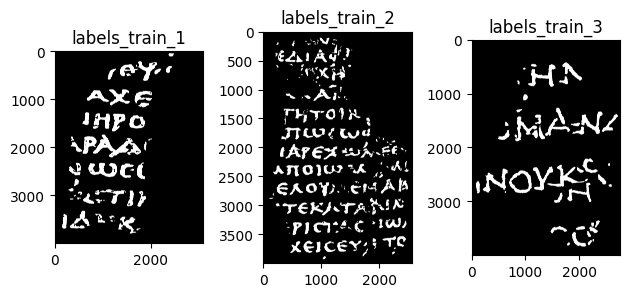

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.set_title("labels_train_1")
ax1.imshow(labels_train_1, cmap='gray')

ax2.set_title("labels_train_2")
ax2.imshow(labels_train_2, cmap='gray')

ax3.set_title("labels_train_3")
ax3.imshow(labels_train_3, cmap='gray')
plt.tight_layout()
plt.show()

In [8]:
def load_volume(split, index):
    # Load the 3d x-ray scan, one slice at a time
    all = sorted(glob.glob(f"{DATA_DIR}/{split}/{index}/surface_volume/*.tif"))
    z_slices_fnames = [all[i] for i in range(len(all)) if i in Z_LIST]
    assert len(z_slices_fnames) == Z_DIM
    z_slices = []
    for z, filename in  tqdm(enumerate(z_slices_fnames)):
        img = cv2.imread(filename, -1)
        img = resize(img)
        # img = (img / (2 ** 8)).astype(np.uint8)
        img = img.astype(np.float32) // 255
        z_slices.append(img)
    return np.stack(z_slices, axis=-1)

In [9]:
volume_train_1 = load_volume(split="train", index=1)
print(f"volume_train_1: {volume_train_1.shape}, {volume_train_1.dtype}")

volume_train_2 = load_volume(split="train", index=2)
print(f"volume_train_2: {volume_train_2.shape}, {volume_train_2.dtype}")

volume_train_3 = load_volume(split="train", index=3)
print(f"volume_train_3: {volume_train_3.shape}, {volume_train_3.dtype}")

# volume = np.concatenate([volume_train_1, volume_train_2, volume_train_3], axis=1)
# volume = np.concatenate([volume_train_1, volume_train_2], axis=1)
# print(f"total volume: {volume.shape}")

17it [00:04,  3.97it/s]


volume_train_1: (4000, 3094, 17), float32


17it [00:06,  2.74it/s]


volume_train_2: (4000, 2563, 17), float32


17it [00:03,  4.40it/s]


volume_train_3: (4000, 2760, 17), float32


In [10]:
# # labels = np.concatenate([labels_train_1, labels_train_2, labels_train_3], axis=1)
# labels = np.concatenate([labels_train_1, labels_train_2], axis=1)
# print(f"labels: {labels.shape}, {labels.dtype}")
# # mask = np.concatenate([mask_train_1, mask_train_2, mask_train_3], axis=1)
# mask = np.concatenate([mask_train_1, mask_train_2], axis=1)
# print(f"mask: {mask.shape}, {mask.dtype}")

In [11]:
# # Free up memory
# del labels_train_1
# del labels_train_2
# del labels_train_3
# del mask_train_1
# del mask_train_2
# del mask_train_3

## Visualize the training data

In this case, not very informative. But remember to always visualize what you're training on, as a sanity check!

In [12]:
# fig, axes = plt.subplots(1, 2, figsize=(15, 3))
# for z, ax in enumerate(axes):
#     ax.imshow(volume[:, :, z], cmap='gray')
#     ax.set_xticks([]); ax.set_yticks([])
# fig.tight_layout()
# plt.show()

## Create a dataset in the input volume


In [13]:
def is_in_masked_zone(location, mask):
    return mask[location[0], location[1]] > 0


In [14]:
def generate_locations_ds(volume, mask):
    is_in_mask_train = lambda x: is_in_masked_zone(x, mask)

    # Create a list to store train locations
    locations = []

    # Generate train locations
    volume_height, volume_width = volume.shape[:-1]

    for y in range(BUFFER, volume_height - BUFFER, int(BUFFER / 1.5)):
        for x in range(BUFFER, volume_width - BUFFER, int(BUFFER / 1.5)):
            if is_in_mask_train((y, x)):
                locations.append((y, x))

    # Convert the list of train locations to a PyTorch tensor
    locations_ds = np.stack(locations, axis=0)
    return locations_ds

## Visualize some training patches

Sanity check visually that our patches are where they should be.

In [15]:
possible_min_input = possible_max_input = all_median = all_MAD = None

In [16]:
from scipy.stats import median_abs_deviation


def calculate_all_MAD(volume):
    global all_MAD
    all_MAD = median_abs_deviation(volume, axis=[0, 1])
    print("all_MAD", all_MAD)

In [17]:
def calculate_all_median(volume):
    global all_median
    all_median = np.median(volume, axis=[0, 1])
    print("all_median", all_median)

In [18]:
def calculate_possibles(all_median, all_MAD):
    global possible_max_input, possible_min_input
    # possible_max_input = ((2 ** 8 - 1) - all_median.min()) / all_MAD.min()
    # possible_min_input = ((0) - all_median.min()) / all_MAD.min()
    possible_max_input = ((2 ** 8 - 1) - all_median.min()) / all_MAD.min()
    possible_min_input = 0

In [19]:
print("all_median", all_median)
"all_median", all_median

all_median None


('all_median', None)

In [20]:
print("all_MAD", all_MAD)
"all_MAD", all_MAD

all_MAD None


('all_MAD', None)

In [21]:
printed = True

def extract_subvolume(location, volume):
    global printed
    # print(np.unique(volume, return_counts=True, return_index=True))
    x = location[0]
    y = location[1]
    subvolume = volume[x-BUFFER:x+BUFFER, y-BUFFER:y+BUFFER, :].astype(np.float32)
    # print("subvolume[:, :, 0]", subvolume[:, :, 0])
    # median = np.full_like(subvolume, all_median).astype(np.float32)
    # MAD = np.full_like(subvolume, all_MAD).astype(np.float32)
    # mean = np.mean(subvolume, axis=2)
    # mean = np.stack([mean for i in range(Z_DIM)], axis=2) + exp
    # MAD = median_abs_deviation(subvolume, axis=2)
    # print("MAD", MAD[0, 0, :])
    # print("mean", mean)
    # print("median", median[0, 0, :])
    
    # subvolume = (subvolume - median) / MAD
    # subvolume = subvolume / median
    
    if not printed:
        print("subvolume after taking care of median and MAD", subvolume)
        printed = True
    
    return subvolume

In [22]:
data = np.array([[120, 24, 54]])
out = A.ToFloat(max_value=2**8-1)(image=data)
out["image"]

array([[0.47058824, 0.09411765, 0.21176471]], dtype=float32)

In [23]:
out = A.FromFloat(max_value=2**8-1)(image=out["image"])
out["image"]

array([[120,  24,  54]], dtype=uint16)

## SubvolumeDataset

In [24]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import OneHotEncoder

from albumentations.core.transforms_interface import ImageOnlyTransform

class NormalizeTransform(ImageOnlyTransform):
    def __init__(self, always_apply=False, p=1.0):
        super(NormalizeTransform, self).__init__(always_apply, p)

    def apply(self, img, **params):
        median = np.full_like(img, all_median).astype(np.float32)
        mad = np.full_like(img, all_MAD).astype(np.float32)
        # img = (img - median) / mad
        img = img / median
        # img[img < 0] = 0
        return img


class SubvolumeDataset(Dataset):
    def __init__(self, locations, volume, labels, buffer, is_train: bool, return_location: bool = False):
        self.locations = locations
        self.volume = volume
        self.labels = labels        
        self.buffer = buffer
        self.is_train = is_train
        self.return_location = return_location

    def __len__(self):
        return len(self.locations)

    def __getitem__(self, idx):
        global possible_min_input, possible_max_input
        label = None
        location = np.array(self.locations[idx])
        y, x = location[0], location[1]

        subvolume = extract_subvolume(location, self.volume)
        # print("subvolume", subvolume)
        # print("labels", labels)
        # subvolume = subvolume.numpy()
        subvolume = subvolume
        
        if self.labels is not None:
            label = self.labels[y - self.buffer:y + self.buffer, x - self.buffer:x + self.buffer]
            # print("label", label)
            # n_category = 2
            # label = np.eye(n_category)[label]
            label = np.stack([label], axis=-1)
            # label = label.numpy()
            # print("label.shape", label.shape
        
        if self.is_train and label is not None:            
            
            # print("label", label.dtype)
            # print("subvolume in train dataset (before aug)", subvolume, file=open("before-train-aug.log", "w")) 
            size = int(BUFFER * 2)
            performed = A.Compose([
                # A.ToFloat(max_value=possible_max_input - possible_min_input),
                # A.ToFloat(max_value=2**16-1),       
                NormalizeTransform(always_apply=True),         
                A.HorizontalFlip(p=0.5), # 水平方向に反転
                A.VerticalFlip(p=0.5), # 水平方向に反転
                A.RandomRotate90(p=0.5),
                # A.RandomBrightnessContrast(p=0.4),
                A.ShiftScaleRotate(p=0.5, border_mode=0), # シフト、スケーリング、回転
                # A.PadIfNeeded(min_height=size, min_width=size, always_apply=True, border_mode=0), # 必要に応じてパディングを追加
                A.RandomCrop(height=int(size / 1.25), width=int(size / 1.25), p=0.5), # ランダムにクロップ, Moduleの中で計算する際に次元がバッチ内で揃っている必要があるので最後にサイズは揃える
                # A.Perspective(p=0.5), # パースペクティブ変換                
                A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
                A.CoarseDropout(max_holes=1, max_width=int(size * 0.1), max_height=int(size * 0.1), 
                                mask_fill_value=0, p=0.2),
                A.OneOf([
                    A.GaussNoise(var_limit=[10, 30]),
                    A.GaussianBlur(blur_limit=(3, 5)),
                    A.MotionBlur(blur_limit=5),
                ], p=0.4),
                A.Resize(BUFFER * 2, BUFFER * 2, always_apply=True),                
                # A.Normalize(
                #     mean= [0] * Z_DIM,
                #     std= [1] * Z_DIM
                # ),
                # A.FromFloat(max_value=possible_max_input - possible_min_input),                
                ToTensorV2(transpose_mask=True),                
            ])(image=subvolume, mask=label)            
            subvolume = performed["image"]
            label = performed["mask"]
            # print("subvolume in train dataset (after aug)", subvolume, file=open("after-train-aug.log", "w"))
            # print("label", label.dtype)
            # print("subvolume", subvolume.dtype)
            # →C, H, W
            # subvolume = torch.from_numpy(subvolume.transpose(2, 0, 1).astype(np.float32))
            # print(performed)
            # print(subvolume.shape, label.shape)
            # H, W, C → C, H, W
            # label = torch.from_numpy(label.transpose(2, 0, 1).astype(np.uint8)) 
        else:
            if label is None:
                performed = A.Compose([            
                    # A.ToFloat(max_value=possible_max_input - possible_min_input),
                    # A.ToFloat(max_value=2**16-1),
                    # A.Normalize(
                    #     mean= [0] * Z_DIM,
                    #     std= [1] * Z_DIM
                    # ),
                    # A.FromFloat(max_value=possible_max_input - possible_min_input),
                    NormalizeTransform(always_apply=True),
                    ToTensorV2(transpose_mask=True),
                ])(image=subvolume)
                subvolume = performed["image"]
            else:
                # print("subvolume in val dataset (before aug)", subvolume, file=open("before-val-aug.log", "w")) 
                performed = A.Compose([            
                    # A.ToFloat(max_value=possible_max_input - possible_min_input),
                    # A.ToFloat(max_value=2**16-1),
                    # A.Normalize(
                    #     mean= [0] * Z_DIM,
                    #     std= [1] * Z_DIM
                    # ),
                    # A.FromFloat(max_value=possible_max_input - possible_min_input),
                    NormalizeTransform(always_apply=True),
                    ToTensorV2(transpose_mask=True),
                ])(image=subvolume, mask=label)                
                label = performed["mask"]                
                subvolume = performed["image"]
                # print("subvolume in val dataset (after aug)", subvolume, file=open("after-val-aug.log", "w"))                
            # subvolume = torch.from_numpy(subvolume.transpose(2, 0, 1).astype(np.float32))
            # if label is not None:
                # label = torch.from_numpy(label.transpose(2, 0, 1).astype(np.uint8)) 
        if self.return_location:
            return subvolume, location
        return subvolume, label        

## Visualize validation dataset patches

Note that they are partially overlapping, since the stride is half the patch size.

In [25]:
def visualize_dataset_patches(locations_ds, labels, mode: str, fold = 0):
    fig, ax = plt.subplots()
    ax.imshow(labels)

    for y, x in locations_ds:
        patch = patches.Rectangle([x - BUFFER, y - BUFFER], 2 * BUFFER, 2 * BUFFER, linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(patch)
    plt.savefig(f"fold-{fold}-{mode}.png")
    plt.show()    

## Compute a trivial baseline

This is the highest validation score you can reach without looking at the inputs.
The model can be considered to have statistical power only if it can beat this baseline.

In [26]:
def trivial_baseline(dataset):
    total = 0
    matches = 0.
    for _, batch_label in tqdm(dataset):
        batch_label = torch.tensor(batch_label)
        matches += torch.sum(batch_label.float())
        total += torch.numel(batch_label)
    return 1. - matches / total

# score = trivial_baseline(val_ds).item()
# print(f"Best validation score achievable trivially: {score * 100:.2f}% accuracy")

## Dataset check

all_MAD [58. 57. 56. 55. 55. 57. 63. 70. 58. 37. 22. 14. 11. 11. 10. 10.  9.]
all_median [58. 57. 56. 55. 55. 57. 63. 70. 58. 57. 70. 80. 84. 85. 86. 86. 86.]


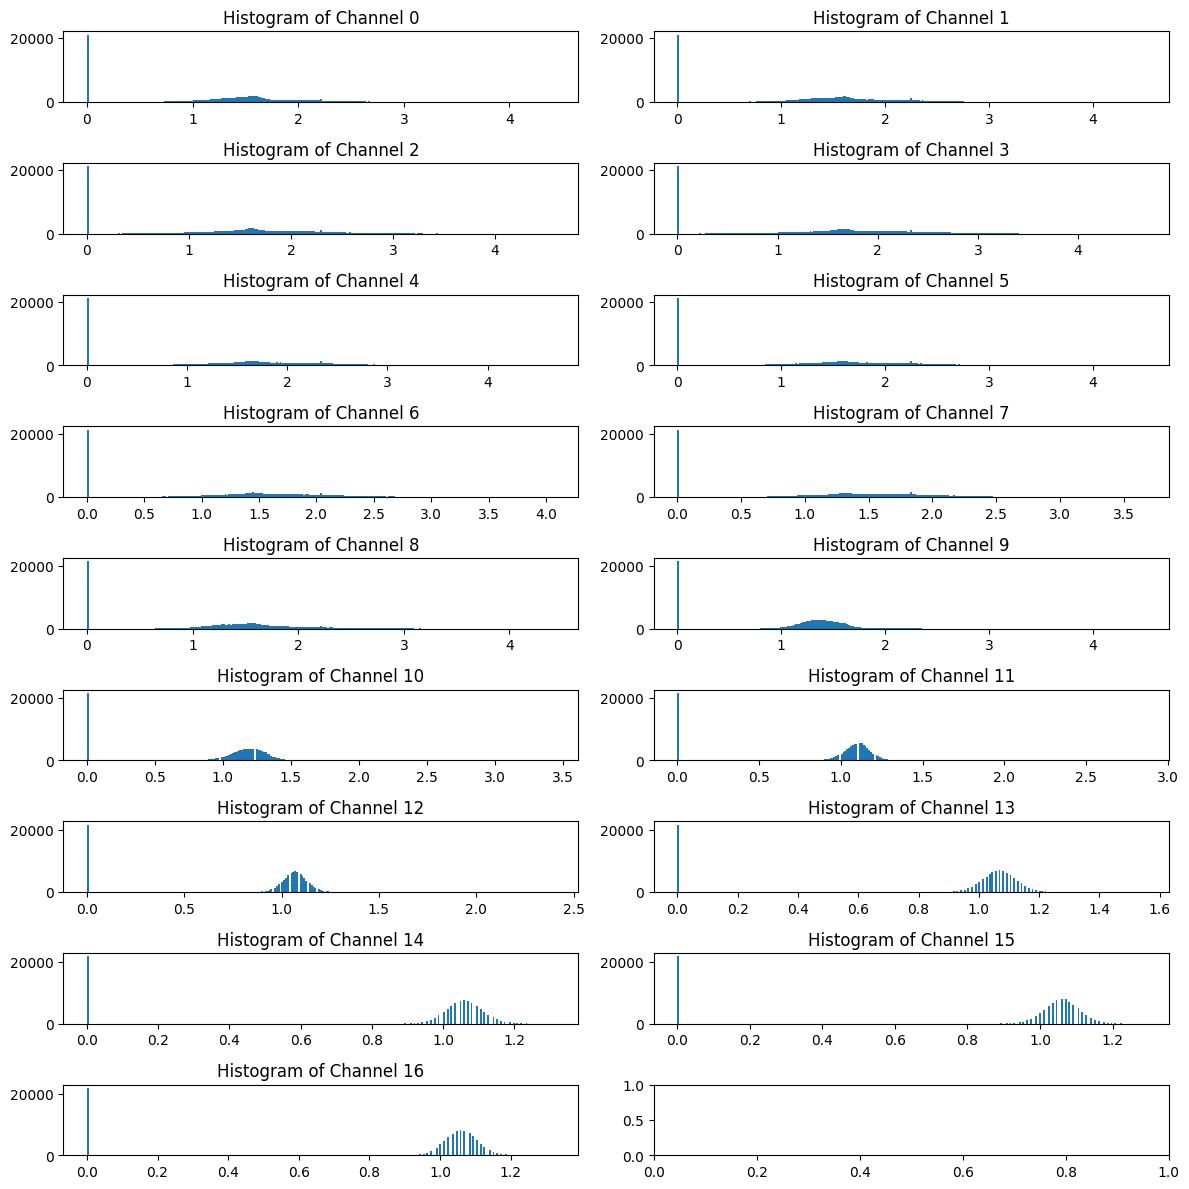

In [27]:
calculate_all_MAD(volume_train_1)

calculate_all_median(volume_train_1)

sample_locations = generate_locations_ds(volume_train_1, mask_train_1)
sample_ds = SubvolumeDataset(
    sample_locations,
    volume_train_1,
    labels_train_1,
    BUFFER,
    is_train=False,
)


fig, ax = plt.subplots(Z_DIM // 2 + 1, 2, figsize=(12, 12))
# Assuming `data` is your (12, 244, 244) array
for i in range(Z_DIM):
    data = sample_ds[0][0][i]
    ax[i // 2][i % 2].hist(data.flatten(), bins=255)  # Plot histogram of the flattened data
    ax[i // 2][i % 2].set_title(f"Histogram of Channel {i}")  # Add title to the plot
fig.tight_layout()
fig.show()  # Display all figures


## Model

In [ ]:
def dice_coef_torch(prob_preds, targets, beta=0.5, smooth=1e-5):
    # No need to binarize the predictions
    # prob_preds = torch.sigmoid(preds)

    # flatten label and prediction tensors
    prob_preds = prob_preds.view(-1).float()
    targets = targets.view(-1).float()

    intersection = (prob_preds * targets).sum()

    dice = ((1 + beta**2) * intersection + smooth) / ((beta**2) * prob_preds.sum() + targets.sum() + smooth)

    return dice



class Model(pl.LightningModule):
    
    training_step_outputs = []
    validation_step_outputs = []
    test_step_outputs = [[], []]

    def __init__(self, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        # self.model = smp.UnetPlusPlus(
        #     encoder_name=encoder_name, 
        #     # encoder_weights="imagenet",
        #     encoder_weights="swsl",
        #     # encoder_weights=None,
        #     encoder_depth=5,
        #     decoder_channels=[512, 256, 128, 64, 32],
        #     in_channels=in_channels,
        #     classes=out_classes,
        #     # aux_params={
        #     #     "pooling": "max",
        #     #     "classes": out_classes,
        #     #     "dropout": 0.2,
        #     #     "activation": None,
        #     # },
        #     **kwargs,
        # )
        self.model = smp.UnetPlusPlus(
            encoder_name=encoder_name, 
            # encoder_weights="imagenet",
            encoder_weights="imagenet",
            # encoder_weights=None,
            encoder_depth=5,
            decoder_channels=[512, 256, 128, 64, 32],
            in_channels=in_channels,
            classes=out_classes,
            # aux_params={
            #     "pooling": "max",
            #     "classes": out_classes,
            #     "dropout": 0.2,
            #     "activation": None,
            # },
            **kwargs,
        )
        
        
        # preprocessing parameteres for image
        # params = smp.encoders.get_preprocessing_params(encoder_name)
        # self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        # self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.segmentation_loss_fn = smp.losses.TverskyLoss(
            smp.losses.BINARY_MODE,
            log_loss=False,
            from_logits=True,
            smooth=1e-6,
        )
        # smp.losses.FocalLoss()
        # self.segmentation_loss_fn = smp.losses.DiceLoss(
        #     smp.losses.BINARY_MODE,
        #     log_loss=False,
        #     from_logits=True,
        #     smooth=1e-6
        # )
        # self.segmentation_loss_fn = dice_coef_torch
        # self.classification_loss_fn = smp.losses.SoftCrossEntropyLoss()

    def forward(self, image):
        # normalize image here
        # image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        
        subvolumes, labels = batch
        
        image, labels = subvolumes.float(), labels.float()
        # print("torch.unique(subvolumes)", torch.unique(subvolumes), file=open("subvolumes_unique", "w"))

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert labels.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert labels.max() <= 1.0 and labels.min() >= 0

        segmentation_out = self.forward(image)
        # print("model out", segmentation_out)
        segmentation_out = segmentation_out.sigmoid()
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.segmentation_loss_fn(segmentation_out, labels)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        prob_mask = segmentation_out 
        pred_mask = (prob_mask > threshold).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), labels.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])
        loss = torch.sum(torch.Tensor([x["loss"] for x in outputs]))

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        
        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
            f"{stage}_loss": loss,
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        out = self.shared_step(batch, "train")
        self.training_step_outputs.append(out)
        return out

    def on_train_epoch_end(self):
        out = self.shared_epoch_end(self.training_step_outputs, "train")
        self.training_step_outputs.clear()
        return out

    def validation_step(self, batch, batch_idx):
        out = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(out)        
        return out

    def on_validation_epoch_end(self):
        out = self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()
        return out

    def test_step(self, batch, batch_idx):
        global predictions_map, predictions_map_counts

        patch_batch, loc_batch = batch
        
        loc_batch = loc_batch.long()
        patch_batch = patch_batch.float()
        predictions: torch.Tensor = self.forward(patch_batch)
        # print("predictions.shape", predictions.shape)
        # print("predictions", predictions)        
        predictions = predictions.sigmoid()
        # print("Softmaxed predictions where conf is gt threshold", predictions[predictions.gt(threshold)])
        # print("predictions.shape after sigmoid", predictions.shape)
        # →(BATCH, W, H, C)
        predictions = torch.permute(predictions, (0, 3, 2, 1))
        predictions = predictions.cpu().numpy()  # move predictions to cpu and convert to numpy
        loc_batch = loc_batch.cpu().numpy()
        # print("predictions_map", predictions_map)
        # print("predictions_map_count", predictions_map_counts)
        self.test_step_outputs[0].extend(loc_batch)
        self.test_step_outputs[1].extend(predictions)
        return loc_batch, predictions

    def on_test_epoch_end(self):
        global predictions_map, predictions_map_counts        
        
        locs = np.array(self.test_step_outputs[0])
        preds = np.array(self.test_step_outputs[1])
        print("locs", locs.shape)
        print("preds", preds.shape)
        
        new_predictions_map = np.zeros_like(predictions_map[:, :, 0])[:, :, np.newaxis]
        new_predictions_map_counts = np.zeros_like(predictions_map_counts[:, :, 0])[:, :, np.newaxis]
        
        for (y, x), pred in zip(locs, preds):
            # print("index: ", index ,"x, y, pred", x.item(), y.item(), pred[BUFFER, BUFFER, :].item(), file=open('log.out', 'a'))
            # print("pred", pred)
            # predictions_map[
            #     x - BUFFER : x + BUFFER, y - BUFFER : y + BUFFER, :
            # ] = np.where(predictions_map[
            #     x - BUFFER : x + BUFFER, y - BUFFER : y + BUFFER, :
            # ] < pred, pred, predictions_map[
            #     x - BUFFER : x + BUFFER, y - BUFFER : y + BUFFER, :
            # ])
            new_predictions_map[
                x - BUFFER : x + BUFFER, y - BUFFER : y + BUFFER, :
            ] += pred
            new_predictions_map_counts[x - BUFFER : x + BUFFER, y - BUFFER : y + BUFFER, :] += 1
        new_predictions_map /= (new_predictions_map_counts + exp)
        new_predictions_map = xp.asarray(new_predictions_map[:, :, 0])
        new_predictions_map: xp.ndarray = denoise_image(new_predictions_map, iter_num=250)
        new_predictions_map = new_predictions_map.get()[:, :, np.newaxis]
        predictions_map = np.concatenate([predictions_map, new_predictions_map], axis=-1)
        print("new_predictions_map", new_predictions_map.shape)
        print("predictions_map", predictions_map.shape)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=lr)
        # Using a scheduler is optional but can be helpful.
        # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.05, patience=5, min_lr=5e-5)
        return {"optimizer": optimizer, "lr_scheduler": { "scheduler": scheduler, "monitor": "valid_dataset_iou" }}


In [ ]:
volume_train_1.shape, labels_train_1.shape, mask_train_1.shape

In [ ]:
# !export CUDA_LAUNCH_BLOCKING=1
# !export TORCH_USE_CUDA_DSA=1

In [ ]:

k_folds = 3
kfold = KFold(
    n_splits=k_folds,
    shuffle=True
)
data_list = [
    (volume_train_1, labels_train_1, mask_train_1),
    (volume_train_2, labels_train_2, mask_train_2),
    (volume_train_3, labels_train_3, mask_train_3),    
]

all_volume = np.concatenate([volume_train_1, volume_train_2, volume_train_3], axis=1)

calculate_all_MAD(all_volume)
calculate_all_median(all_volume)
calculate_possibles(all_median, all_MAD)

for fold, (train_data, val_data) in enumerate(kfold.split(data_list)):
    print(f'FOLD {fold}')
    print('--------------------------------')
    print("train_data", train_data)
    print("val_data", val_data)
    one = data_list[train_data[0]]
    two = data_list[train_data[1]]
    three = (rotate90(one[0]), rotate90(one[1]), rotate90(one[2]))
    four = (rotate90(two[0]), rotate90(two[1]), rotate90(two[2]))
    train_volume = np.concatenate([one[0], two[0], three[0], four[0]], axis=1)
    train_label = np.concatenate([one[1], two[1], three[1], four[1]], axis=1)
    train_mask = np.concatenate([one[2], two[2], three[2], four[2]], axis=1)
    val_volume, val_label, val_mask = data_list[val_data[0]]    

    # val_volume = [val_volume for i in range(1)]
    # val_mask = [val_mask for i in range(1)]
    # val_label = [val_label for i in range(1)]
    # for i in range(1):
    #     val_volume[i] = rotate90(val_volume[i], k=i, reverse=False)
    #     val_label[i] = rotate90(val_label[i], k=i, reverse=False)
    #     val_mask[i] = rotate90(val_mask[i], k=i, reverse=False)
    
    # val_volume = np.concatenate(val_volume, axis=1)
    # val_label = np.concatenate(val_label, axis=1)
    # val_mask = np.concatenate(val_mask, axis=1)
    
    train_locations_ds = generate_locations_ds(train_volume, train_mask)
    val_location_ds = generate_locations_ds(val_volume, val_mask)       

    visualize_dataset_patches(train_locations_ds, train_label, "train", fold)
    visualize_dataset_patches(val_location_ds, val_label, "val", fold)
    
    # Init the neural network
    model = Model(
        encoder_name=backbone,
        in_channels=Z_DIM,
        out_classes=1,
    )

    # Initialize a trainer
    trainer = pl.Trainer(
        max_epochs=num_epochs,
        devices="auto",
        accelerator="auto",
        # strategy="ddp_find_unused_parameters_false",
        # strategy="ddp_fork",
    )
    
    # Sample elements randomly from a given list of ids, no replacement.
    train_ds = SubvolumeDataset(
        train_locations_ds,
        train_volume,
        train_label,
        BUFFER,
        is_train=True
    )
    val_ds = SubvolumeDataset(
        val_location_ds,
        val_volume,
        val_label,
        BUFFER,
        is_train=False,
    )
    
    # Define data loaders for training and testing data in this fold
    train_loader = torch.utils.data.DataLoader(
        train_ds, 
        batch_size=BATCH_SIZE,
        num_workers=num_workers,
        shuffle=True,
    )
    val_loader = torch.utils.data.DataLoader(
        val_ds, 
        batch_size=BATCH_SIZE,
        num_workers=num_workers,
        shuffle=False,
    )

    # Train the model
    trainer.fit(model, train_loader, val_loader)


In [ ]:
print("all_median", all_median)
all_median

In [ ]:
print("all_MAD", all_MAD)
all_MAD